# Fruit and Vegetable Image Classification
This dataset is about the classification of images of fruits and vegetables into one of 36 categories (10 fruits, 26 vegetables). Data were collected from Bing Image Search and uploaded to Kaggle where I got them from.

Dataset citation:

Kritik Seth, "Fruits and Vegetables Image Recognition Dataset," Kaggle 2020 [https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition]

Necessary imports and other utilities

In [ ]:
#pip install lime

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..'))
    import lime
from lime import lime_image

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, MaxPool2D, MaxPooling2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from IPython.display import Image
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.segmentation import mark_boundaries

# https://drive.google.com/drive/folders/1OWIM2lFwjcSvTS4T4zFFkNnpN5qU_1d-?usp=sharing

### Dataset Analysis
After examination of the dataset, I found that it is far from perfect. The biggest problem was that the test and validation data were identical, and also most of the images from the test data were also in the training data, which would guarantee the model high accuracy but would not reflect its true ability to classify unseen images.

Another problem was that some categories were indistinguishable from each other (corn-sweetcorn, bell pepper-capsicum), or they contained a large part of pictures from other categories (bell-pepper-capsicum, corn-sweetcorn, jalapeno-chilli pepper-pepper) which may have been due to the fact that Bing Image Search is not perfect and while collecting data, the images from several categories could be collected into one. Therefore, I have decided to remove the categories sweetcorn (identical to corn), capsicum (identical to bell pepper), chilli pepper (many pictures from category jalapeno, paprika, bell pepper), paprika (pictures of spices instead of pepper itself, many pictures from category jalapeno, chilli pepper, bell pepper).


Finally, I removed unrelated images such as Apple logos in the apple category, and pictures with several types of different fruits on picture.


The original dataset had 3825 images in 36 categories divided into 3107/359/359 images in train / validation / test folders. After eliminating the above problems, I was left with 1919/320/320 images in 32 categories


### Data loading

First we load the images into a lists and then we convert them to a DataFrame in the form so that it can be put into the ImageDataGenerator from the Keras library.

In [ ]:
train_dir = Path('data/train')
train_filepaths = list(train_dir.glob(r'**/Image*.*'))

test_dir = Path('data/test')
test_filepaths = list(test_dir.glob(r'**/Image*.*'))

val_dir = Path('data/validation')
val_filepaths = list(test_dir.glob(r'**/Image*.*'))

def create_dataframe(filepath):
    #Creates dataframe with filepath and label columns

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)
    return df

train_df = create_dataframe(train_filepaths)
test_df = create_dataframe(test_filepaths)
val_df = create_dataframe(val_filepaths)

In [ ]:
train_df.head()

Filepath    Label
0   data\train\grapes\Image_85.jpg   grapes
1  data\train\lettuce\Image_48.jpg  lettuce
2   data\train\carrot\Image_27.jpg   carrot
3  data\train\cabbage\Image_69.JPG  cabbage
4   data\train\tomato\Image_97.jpg   tomato

In [ ]:
NUM_LABELS = len(train_df.Label.unique())
print(f'Number of labels: {NUM_LABELS}')
print(f'Number of pictures for training: {train_df.shape[0]}')
print(f'Number of pictures for validation: {val_df.shape[0]}')
print(f'Number of pictures for testing: {test_df.shape[0]}')

Number of labels: 32
Number of pictures for training: 1919
Number of pictures for validation: 320
Number of pictures for testing: 320


We will draw one picture from each category to make sure we have done everything correctly.


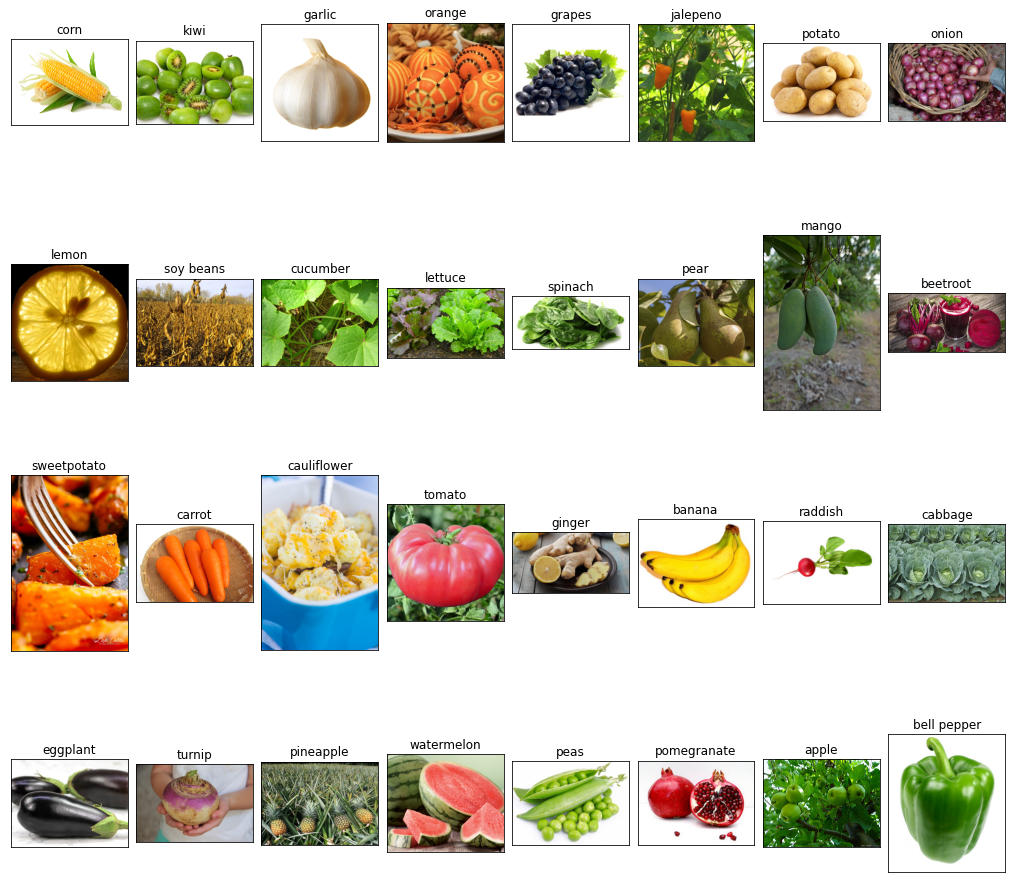

In [ ]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 14),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

### Preprocessing
For data preprocessing, I used the ImageDataGenerator class from the Keras library, which can retrieve data from prepared DataFrames. We chose this class mainly because it can apply different augmentations to the images during the training of the model, which actually "increases" the number of different images that the model will see (and will not see and learn from the same 1919 images in each iteration) which is ideal since we don't have satisfiable amount of training data at all.


I used the following to augment the images:

Rotation: helps the model become invariant to the orientation of the object

Shifts: helps the model with different position of the object in the picture (it doesn't always have to be in the middle)

Flip: similar to rotation

Zoom: helps with different object sizes

Shear: simulates different angles of view


Next I will crop the image to the model input's required size. I will also mix training and validation data in each iteration of the model so that the images do not always go in the same order which helps the model

I will not apply any augmentations to the test data because we want to classify the original images and also I will not shuffle them to maintain their order (so I can find their label later)

In [ ]:
def preprocess_data(train_df, val_df, test_df, target_size, prep_func):
    # Preprocesses given dataframes with data augmentations and prep_func, 
    # crops images to target_size and returns preprocessed images
    
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=prep_func
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=prep_func
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=target_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        seed=0,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='Filepath',
        y_col='Label',
        target_size=target_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        seed=0,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=target_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_images, val_images, test_images

### Utils
Here are some functions that are used multiple times, so they are not randomly scattered over the notebook)

In [11]:
def fit_model(model, epochs, patience):
    # Runs model training with given number of epochs and early stopping patience
    history = model.fit(
        train_images,
        validation_data=val_images,
        batch_size = 32,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True
            )
        ]   
    ) 
    return history

def print_val_loss(history):
    # Prints information about model history in readable format
    min_val_loss = min(history['val_loss'])
    epoch_num = history['val_loss'].index(min_val_loss)
    train_acc = history['accuracy'][history['val_loss'].index(min_val_loss)]
    val_acc = history['val_accuracy'][history['val_loss'].index(min_val_loss)]
    print(f"Lowest val_loss {min_val_loss} with val_acc {round(100*val_acc, 3)}% at epoch number {epoch_num} with training accuracy {round(100*train_acc, 3)}%")

def print_images(imgs):
    # Plots images
    imgs, _ = next(train_images)

    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 14))
    axes = axes.flatten()
    for im, ax in zip(imgs, axes):
        ax.imshow(im)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def plot_loss_acc(history):
    # Plots history of model
    pd.DataFrame(history)[['accuracy','val_accuracy']].plot()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

    pd.DataFrame(history)[['loss','val_loss']].plot()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

def get_y_pred(model, train_images, test_images):
    # Returns predictions of given model on test data
    predictions = model.predict(test_images)
    predictions = np.argmax(predictions,axis=1)

    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    y_pred = [labels[k] for k in predictions]
    y_test = [labels[k] for k in test_images.classes]
    return y_pred, y_test

def get_right_preds(y_pred, y_test):
    # Returns indexes of correct predictions
    right_pred = []
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            right_pred.append(i)
    print(len(right_pred))
    return right_pred

def get_wrong_preds(y_pred, y_test):
    # Returns indexes of wrong predictions
    wrong_pred = []
    for i in range(len(y_pred)):
        if y_pred[i] != y_test[i]:
            wrong_pred.append(i)
    print(len(wrong_pred))
    return wrong_pred

def plot_preds(y_pred, pred, x, y):
    # Plots x*y images of given predictions
    fig, axes = plt.subplots(x, y, figsize=(8, 8),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Filepath.iloc[pred[i]]))
        ax.set_title(f"True: {test_df.Label.iloc[pred[i]]}\nPredicted: {y_pred[pred[i]]}")
    plt.tight_layout()
    plt.show()

def transform_img_fn(path_list, size):
    # Needed for function below
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

def show_lime_superpixels(moodel, img, size, num):
    # Prints num of LIME superpixels for given model and images, with given size
    images = transform_img_fn([img], size)

    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(images[0].astype('double'), moodel.predict, hide_color=0, top_labels=5, num_samples=100)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num, hide_rest=False)
    #plt.imshow(mark_boundaries(temp, mask))

    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    imgPath = img

    imge = image.load_img(imgPath, target_size=size)

    axarr[0].imshow(imge)
    axarr[1].imshow(mask)
    axarr[2].imshow(imge)
    axarr[2].imshow(mask, alpha=0.7)

### Model selection
As for models used, I chose Convolutional Neural Networks (CNN), as they are the most popular choice for image classification today. Specifically, I chose one manually created CNN as the baseline model and one pretrained CNN with transfer learning technique.

### Baseline model
As a simple baseline model, I manually created a CNN. This model was created by trial and error, but I did not manage to make one that exceeded 50% accuracy

Image preprocessing

In [ ]:
train_images, val_images, test_images = preprocess_data(train_df, val_df, test_df, (224, 224), 
                                                        None)

Found 1919 validated image filenames belonging to 32 classes.
Found 320 validated image filenames belonging to 32 classes.
Found 320 validated image filenames belonging to 32 classes.


CNN creation

In [ ]:
model_base = Sequential()
model_base.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_base.add(MaxPooling2D(pool_size=(2,2)))
model_base.add(BatchNormalization())
model_base.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_base.add(MaxPooling2D(pool_size=(2,2)))
model_base.add(BatchNormalization())
model_base.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_base.add(MaxPooling2D(pool_size=(2,2)))
model_base.add(BatchNormalization())
model_base.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model_base.add(MaxPooling2D(pool_size=(2,2)))
model_base.add(BatchNormalization())
model_base.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_base.add(MaxPooling2D(pool_size=(2,2)))
model_base.add(BatchNormalization())
model_base.add(Dropout(0.2))
model_base.add(Flatten())
model_base.add(Dense(128, activation='relu'))
model_base.add(Dropout(0.3))
model_base.add(Dense(NUM_LABELS, activation = 'softmax'))

In [ ]:
model_base.summary()

Model compilation, as an optimizer I used "adam" because the adaptive optimizer is probably the best and works faster than the others. Categorical-crossentropy is chosen because we have a multi-class classification problem and we are interested in the accuracy with which the model matches correctly.

In [ ]:
model_base.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

This is followed by model training for 30 epochs with an early stop if model does not improve validation accuracy for 4 epochs.

In [ ]:
history_base = fit_model(model_base, 30, 4)

Epoch 1/30
 5/60 [=>............................] - ETA: 3:34 - loss: 4.3239 - accuracy: 0.0437

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/60 [===========>..................] - ETA: 2:32 - loss: 3.9780 - accuracy: 0.0730

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


60/60 [==============================] - 276s 5s/step - loss: 3.6721 - accuracy: 0.0959 - val_loss: 4.0581 - val_accuracy: 0.0750
Epoch 2/30
60/60 [==============================] - 256s 4s/step - loss: 2.8065 - accuracy: 0.2084 - val_loss: 2.9549 - val_accuracy: 0.1688
Epoch 3/30
60/60 [==============================] - 268s 4s/step - loss: 2.4530 - accuracy: 0.3054 - val_loss: 2.4576 - val_accuracy: 0.2812
Epoch 4/30
60/60 [==============================] - 255s 4s/step - loss: 2.1905 - accuracy: 0.3455 - val_loss: 2.1410 - val_accuracy: 0.3187
Epoch 5/30
60/60 [==============================] - 256s 4s/step - loss: 1.9710 - accuracy: 0.4106 - val_loss: 2.2772 - val_accuracy: 0.3594
Epoch 6/30
60/60 [==============================] - 256s 4s/step - loss: 1.8160 - accuracy: 0.4601 - val_loss: 1.9841 - val_accuracy: 0.4000
Epoch 7/30
60/60 [==============================] - 255s 4s/step - loss: 1.6336 - accuracy: 0.4950 - val_loss: 1.9282 - val_accuracy: 0.3938
Epoch 8/30
60/60 [======

Cells to save/load model/model history if needed.

In [ ]:
with open('history baseline', 'wb') as file_pi:
        pickle.dump(history_base.history, file_pi)
model_base.save("
                model baseline")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/IB031 Project/model baseline/assets


In [8]:
history_base = pickle.load(open('history baseline', "rb"))
#model_base = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/IB031 Project/model baseline")
used_load = True

Training and validation accuracy plot

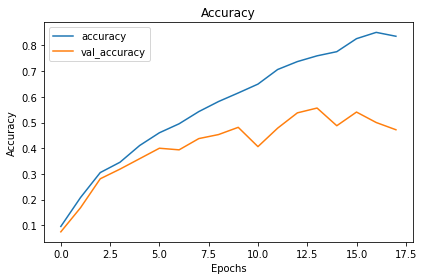

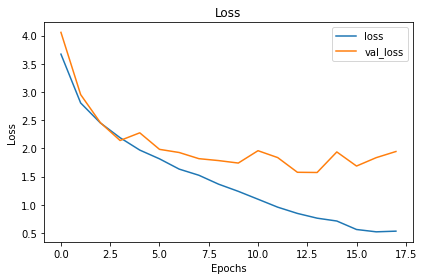

In [ ]:
if used_load:
    plot_loss_acc(history_base)
else:
    plot_loss_acc(history_base.history)

Store predictions on test data

In [ ]:
y_pred, y_test = get_y_pred(model_base, train_images, test_images)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Accuracy of the model on test data. Accuracy counts how many % of images have been placed in the correct category.

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test set: {round(acc*100, 3)}%')

Accuracy on the test set: 47.812%


Confusion matrix of predictions

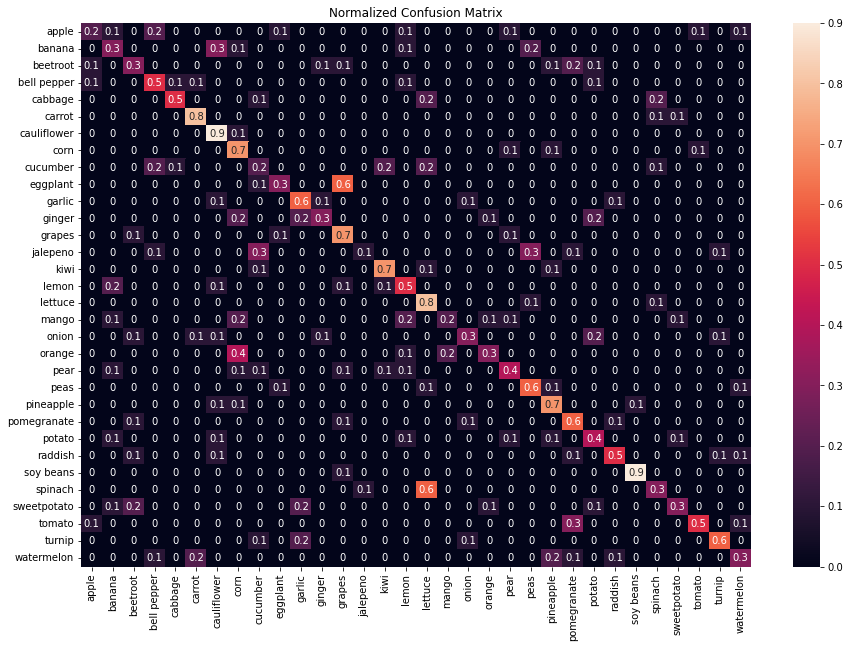

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

From the above matrix we can immediately see that the model is not perfect. It learned to recognize some categories relatively well, especially those that do not have many other similar categories, such as pineapple, cauliflower, soy beans or kiwi. On the other hand, the model has a huge problem recognizing categories with a similar shape (various round/long fruits/vegetables), which will probably be due to the small number of parameters and layers of the CNN, so the model probably did not have much time to recognize more detailed properties but rather only basic shapes.

In [ ]:
wrong_predictions = get_wrong_preds(y_pred, y_test)
right_predictions = get_right_preds(y_pred, y_test)

167
153



Let's draw a few incorrect predictions

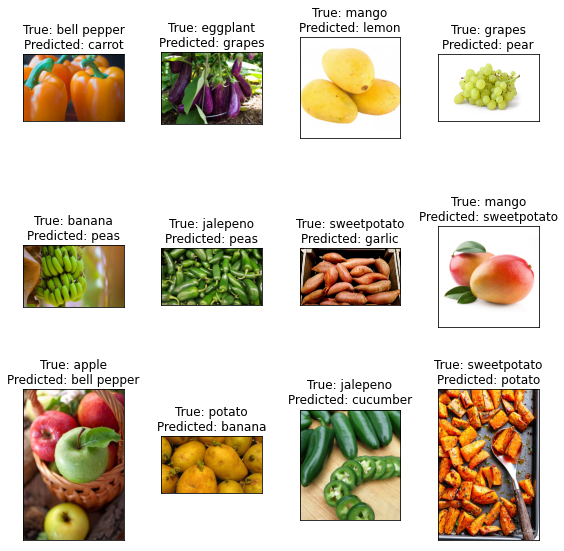

In [ ]:
plot_preds(y_pred, wrong_predictions, x=3, y=4)

Let's draw a few correct predictions, it could be said that correctly classified images look "easier to recognize" compared to wrongly classified ones.

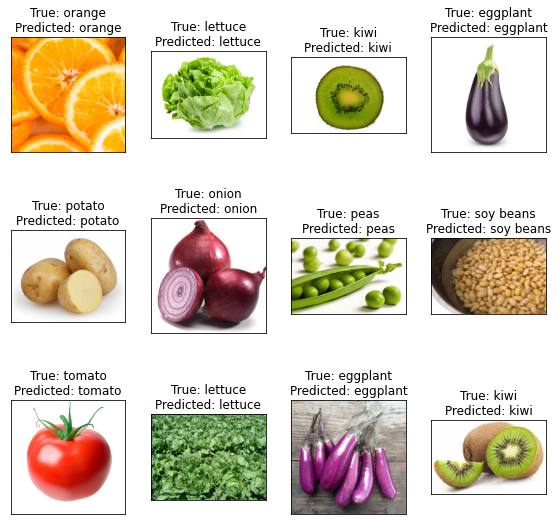

In [ ]:
plot_preds(y_pred, right_predictions, x=3, y=4)

Now, using the LIME technique, we draw a few "superpixels", which the model in the picture considers to be the most important and judged by them that the object belongs to the selected category. If the selected superpixels make sense, we can conclude that the model has learned to recognize the image correctly.

Let's draw some of the correctly ranked pictures shown above.

In most images, the model captures relatively correct parts of the image according to which it could really be concluded that this is a correct category. Although the model is far from good with 47% accuracy, it can recognize some simpler images correctly and is not completely unusable.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

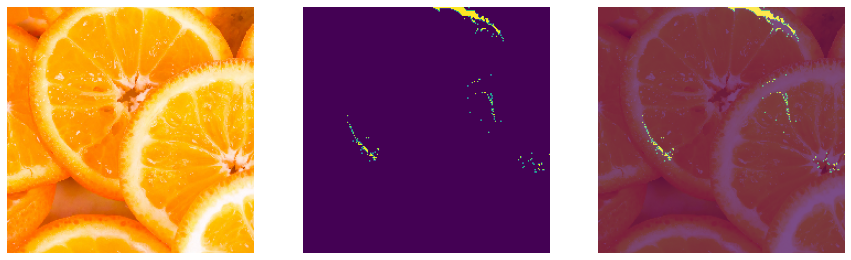

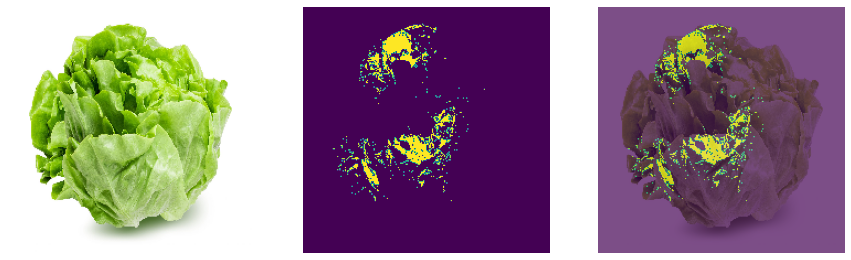

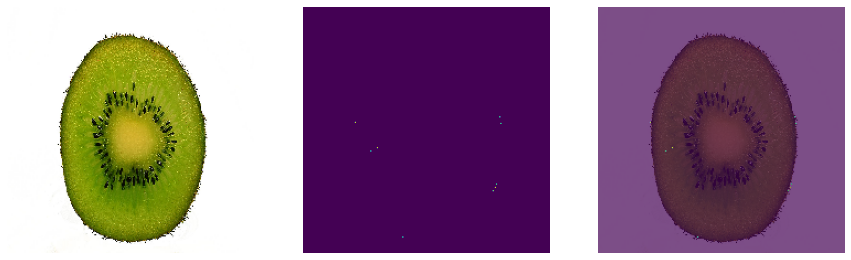

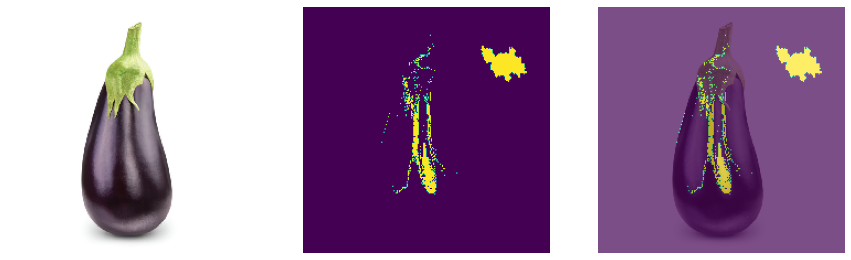

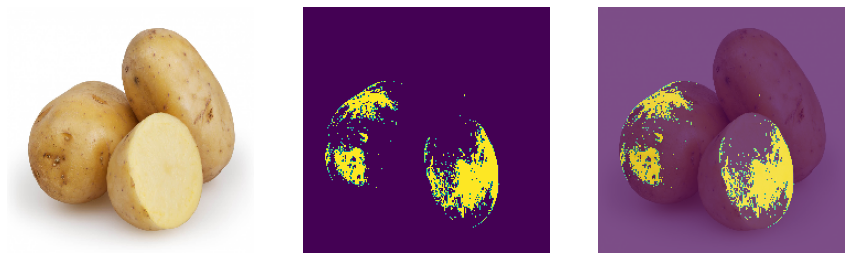

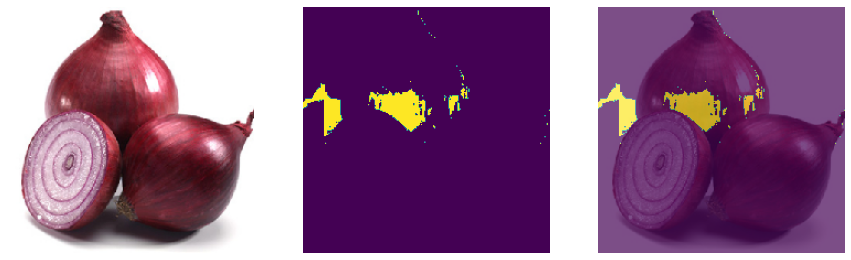

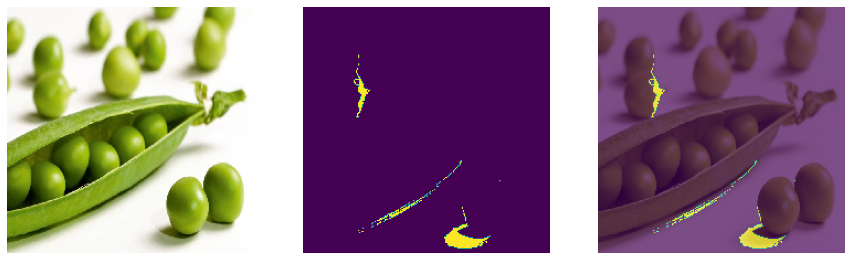

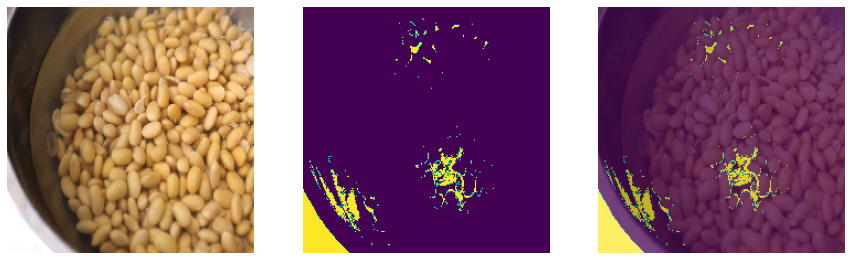

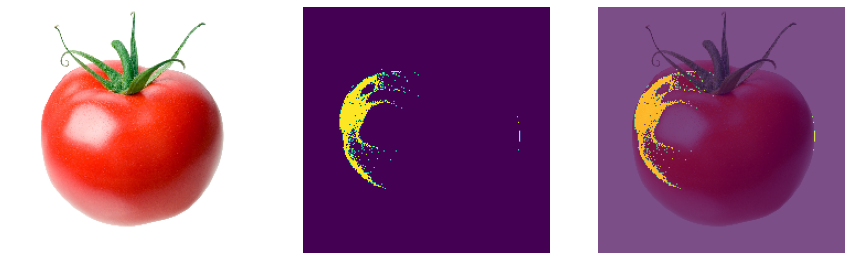

In [ ]:
for i in range(9):
    show_lime_superpixels(model_base, test_df.Filepath.iloc[right_predictions[i]], (224, 224), 5)

### Transfer Learning
Transfer learning is a technique in machine learning that generally refers to a process in which a trained model for one problem is somehow applied to another related problem.
We will use pre-trained neural networks on the Imagenet dataset, which contains 1000 different classes, many of which are also in our categories.
Specifically, we will use these pre-trained models by using all their layers except the top ones fully connected, thus gaining all the features that this network has ever learned on the Imagenet dataset, and supplementing this network with our own fully connected layers that extract the necessary features from those convolution our problem.

I decided to use pretrained CNN EfficientNetB2: 9.2 million parameters, depth 186 layers (reached 80.1% / 94.9% Top1 / Top5 accuracy on ImageNet dataset)

(For comparison, the baseline model has 7 layers with 637,056 parameters)

### EfficientNet

I will prepare the data for the required 260x260 size and use the function created for EfficientNet for preprocessing (even though the documentation says that this function no longer needs to be used and does nothing)

In [ ]:
# tf.keras.applications.efficientnet.preprocess_input    (260, 260)
train_images, val_images, test_images = preprocess_data(train_df, val_df, test_df, (260, 260), 
                                                        tf.keras.applications.efficientnet.preprocess_input)

Found 1919 validated image filenames belonging to 32 classes.
Found 320 validated image filenames belonging to 32 classes.
Found 320 validated image filenames belonging to 32 classes.


In [ ]:
def create_cnn_efficientnet(num_neurons, dropout_rate, learning_rate, pool):
    pretrained_model = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights='imagenet',
    pooling=pool
    )
    pretrained_model.trainable = False

    headModel = pretrained_model.output
    headModel = tf.keras.layers.Dense(num_neurons, activation="relu")(headModel)
    if dropout_rate != 0.0:
        headModel = tf.keras.layers.Dropout(dropout_rate)(headModel)
    headModel = tf.keras.layers.Dense(NUM_LABELS, activation="softmax")(headModel)

    model = tf.keras.Model(inputs=pretrained_model.input, outputs=headModel)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model_eff = create_cnn_efficientnet(num_neurons=128, dropout_rate=0.5, learning_rate=0.001, pool='avg')

In [ ]:
model_eff.summary()

40 epoch training with an early stop unless the validation loss improves over 5 epochs.

In [ ]:
history_eff = model_eff.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=40,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    
)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/40
 4/60 [=>............................] - ETA: 44s - loss: 3.4047 - accuracy: 0.0625

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


60/60 [==============================] - 107s 2s/step - loss: 2.2529 - accuracy: 0.4492 - val_loss: 0.7608 - val_accuracy: 0.8469
Epoch 2/40
60/60 [==============================] - 95s 2s/step - loss: 0.9170 - accuracy: 0.7551 - val_loss: 0.3492 - val_accuracy: 0.9094
Epoch 3/40
60/60 [==============================] - 92s 2s/step - loss: 0.6042 - accuracy: 0.8431 - val_loss: 0.2849 - val_accuracy: 0.9281
Epoch 4/40
60/60 [==============================] - 91s 2s/step - loss: 0.4754 - accuracy: 0.8692 - val_loss: 0.2375 - val_accuracy: 0.9344
Epoch 5/40
60/60 [==============================] - 90s 2s/step - loss: 0.3899 - accuracy: 0.8869 - val_loss: 0.1943 - val_accuracy: 0.9531
Epoch 6/40
60/60 [==============================] - 91s 2s/step - loss: 0.3378 - accuracy: 0.9067 - val_loss: 0.1877 - val_accuracy: 0.9438
Epoch 7/40
60/60 [==============================] - 92s 2s/step - loss: 0.2693 - accuracy: 0.9297 - val_loss: 0.1762 - val_accuracy: 0.9469
Epoch 8/40
60/60 [============

We can see that EfficientNet achieved higher validation accuracy after only one epoch and reached its maximum after 22 epochs with a validation loss of 0.143 and 95.63% accuracy

Utilities for saving/loading

In [ ]:
with open('history efficientnet base', 'wb') as file_pi:
        pickle.dump(history_eff.history, file_pi)
model_eff.save("IB031 Project/model efficientnet base")

In [ ]:
model_eff = tf.keras.models.load_model("model efficientnet base")

In [9]:
history_eff = pickle.load(open('history efficientnet base', "rb"))
used_load = True

Plot training process

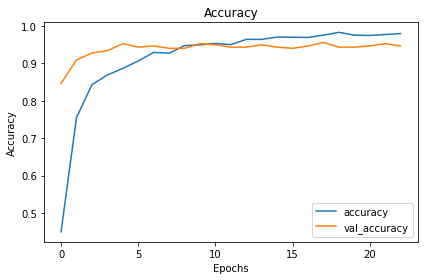

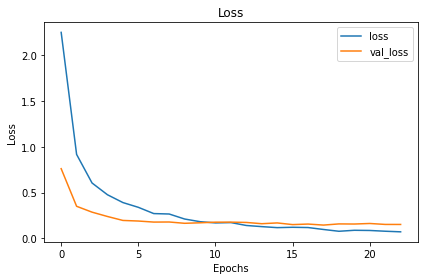

In [ ]:
if used_load:
    plot_loss_acc(history_eff)
else:
    plot_loss_acc(history_eff.history)

The search for the best hyperparameters was done outside of this notebook. Since the training took long time, I decided not to use GridSearch for hyperparameter tuning, but I tried to smartly choose some hyperparameters that I found important, but no combination did beat the first variation created above, so that one was chosen for further testing.



In [ ]:
history_128_05_001_32_avg = pickle.load(open('history efficientnet base', "rb"))
history_128_05_001_32_max = pickle.load(open('history efficientnet maxpool', "rb"))
history_128_00_001_32_avg = pickle.load(open('history efficientnet no dropout', "rb"))
history_128_02_001_32_avg = pickle.load(open('history efficientnet dropout 0.2', "rb"))
history_128_08_001_32_avg = pickle.load(open('history efficientnet dropout 0.8', "rb"))
history_64_05_001_32_avg = pickle.load(open('history efficientnet 64neu', "rb"))
history_256_05_001_32_avg = pickle.load(open('history efficientnet 256neu', "rb"))
history_512_05_001_32_avg = pickle.load(open('history efficientnet 512neu', "rb"))
history_512_08_001_32_avg = pickle.load(open('history efficientnet 512neu 0.8drop', "rb"))
history_128_05_0001_32_avg = pickle.load(open('history efficientnet 0.0001 lr', "rb"))
history_128_05_0005_32_avg = pickle.load(open('history efficientnet 0.0005 lr', "rb"))
history_128_05_01_32_avg = pickle.load(open('history efficientnet 0.01', "rb"))
history_128_05_001_64_avg = pickle.load(open('history efficientnet base batch64', "rb"))

In [ ]:
efficientnet_histories = [history_128_05_001_32_avg,
                          history_128_05_001_32_max,
                          history_128_00_001_32_avg,
                          history_128_02_001_32_avg,
                          history_128_08_001_32_avg,
                          history_64_05_001_32_avg,
                          history_256_05_001_32_avg,
                          history_512_05_001_32_avg,
                          history_512_08_001_32_avg,
                          history_128_05_0001_32_avg,
                          history_128_05_01_32_avg,
                          history_128_05_001_64_avg]

In [ ]:
for hist in efficientnet_histories:
    print_val_loss(hist)

Lowest val_loss 0.1433524489402771 with val_acc 95.625% at epoch number 17 with training accuracy 97.603%
Lowest val_loss 0.6027270555496216 with val_acc 83.125% at epoch number 30 with training accuracy 53.306%
Lowest val_loss 0.15033552050590515 with val_acc 94.375% at epoch number 12 with training accuracy 99.531%
Lowest val_loss 0.14427229762077332 with val_acc 94.375% at epoch number 22 with training accuracy 99.167%
Lowest val_loss 0.18552948534488678 with val_acc 94.063% at epoch number 13 with training accuracy 77.876%
Lowest val_loss 0.19101384282112122 with val_acc 94.063% at epoch number 14 with training accuracy 91.671%
Lowest val_loss 0.15938501060009003 with val_acc 94.063% at epoch number 11 with training accuracy 97.603%
Lowest val_loss 0.15333810448646545 with val_acc 94.375% at epoch number 6 with training accuracy 96.773%
Lowest val_loss 0.1674925535917282 with val_acc 94.063% at epoch number 10 with training accuracy 91.567%
Lowest val_loss 0.20833687484264374 with 

In [ ]:
plot_loss_acc(history_128_05_001_32_avg)

In [ ]:
y_pred, y_test = get_y_pred(model_eff, train_images, test_images)

We will use accuracy again to evaluate the model.

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test set: {round(acc*100, 3)}%')

Accuracy on the test set: 95.625%


Draw a confusion matrix on which we can tell that the most problematic category was mango, which was confused with lemon, orange, pear, potato and apple (which also makes sense, because as we will see in a while, it is quite similar to all of the above).

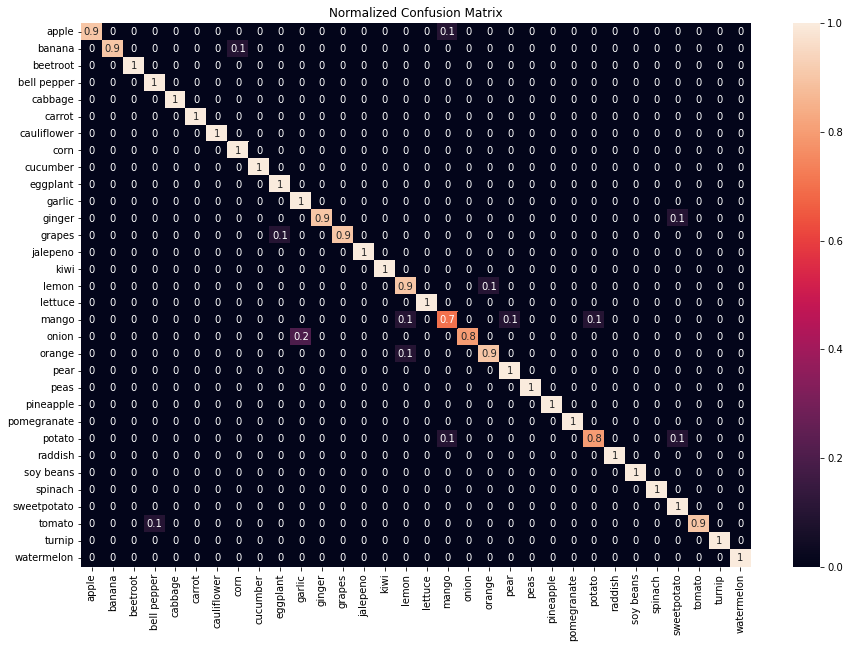

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
wrong_predictions = get_wrong_preds(y_pred, y_test)
right_predictions = get_right_preds(y_pred, y_test)

14
306


As we can see, most misclassified fruits/vegetables are difficult to recognize at first glance (especially all those mangoes) and you can understand why the CNN made a mistake (especially banana-corn is very interesting, or even the onion-garlic ones, the two objects on the right resemble garlic pods, but after closer inspection they are onion wrapss).

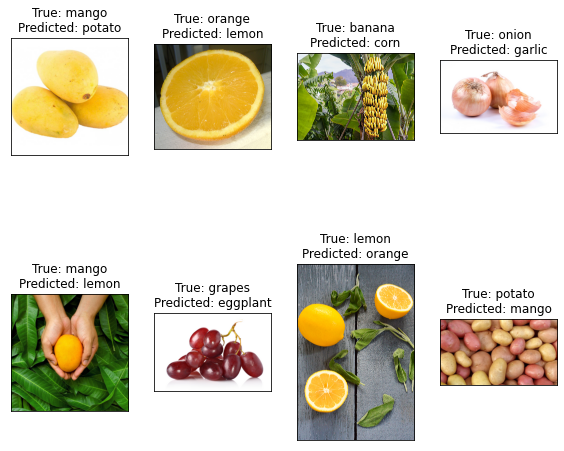

In [ ]:
plot_preds(y_pred, wrong_predictions, x=2, y=4)

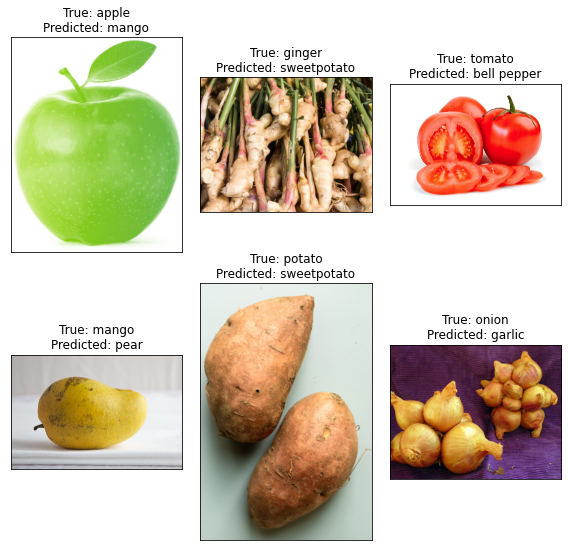

In [ ]:
plot_preds(y_pred, wrong_predictions[-6:], x=2, y=3)

Using LIME, we will again look according to which parts of the picture the CNN was wrong about the given fruit/vegetable.

We can see that in most cases the CNN also chose the right part of the picture, but it still misjudged it because the mistaken categories are quite similar. In the case of a tree with bananas, it is difficult to say what went wrong and the picture of the apple I do not know why it is badly rendered.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

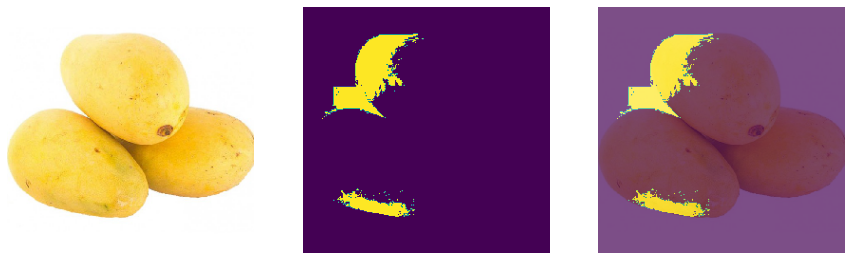

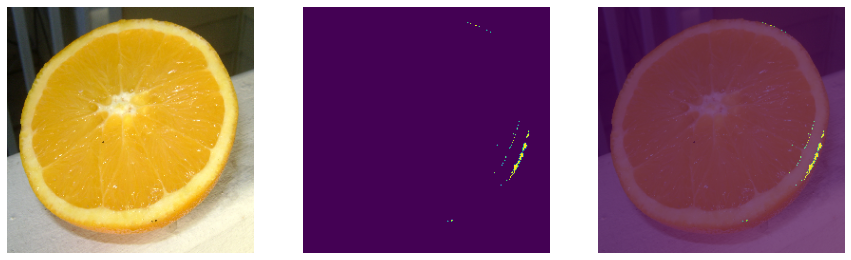

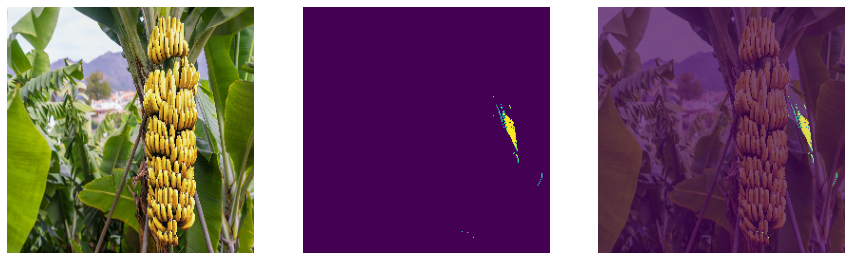

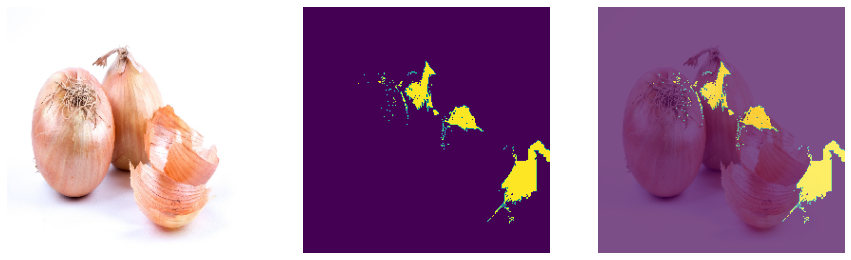

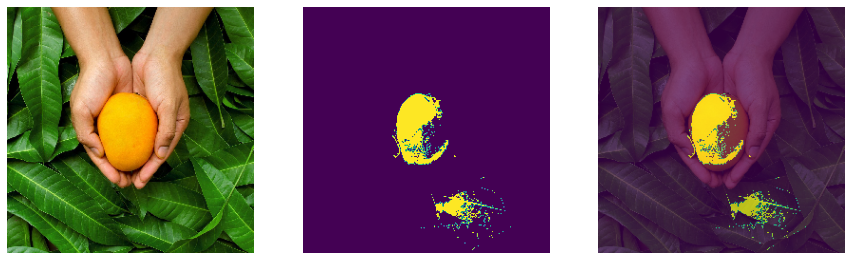

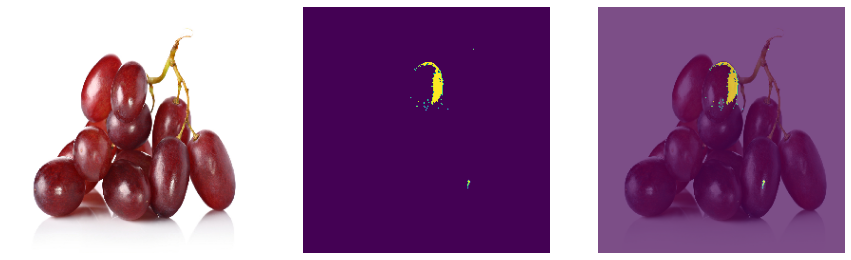

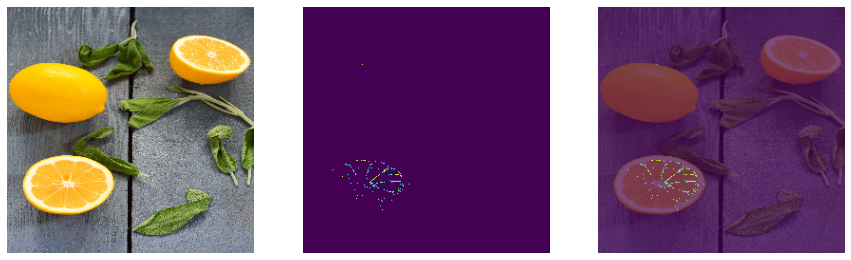

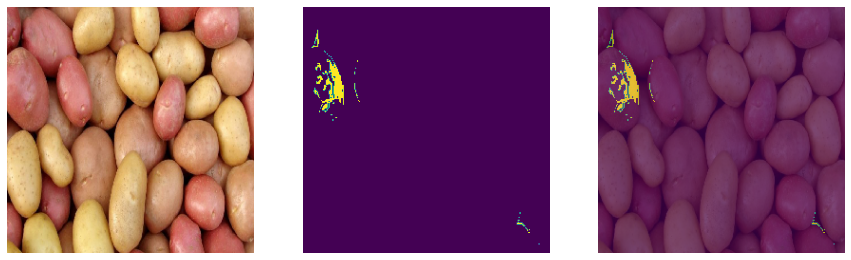

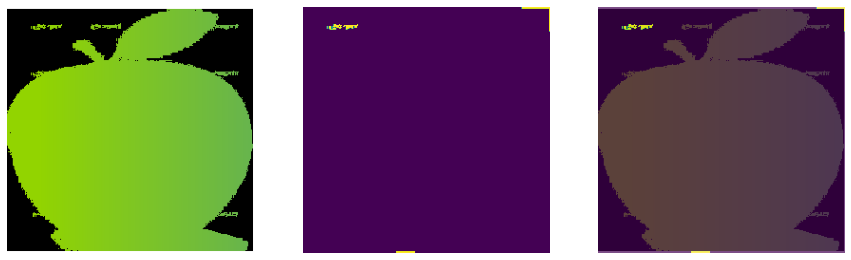

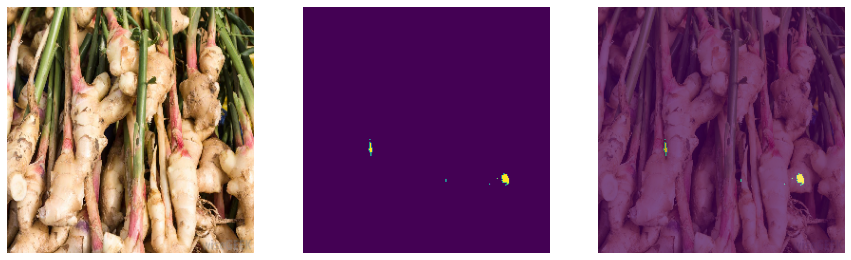

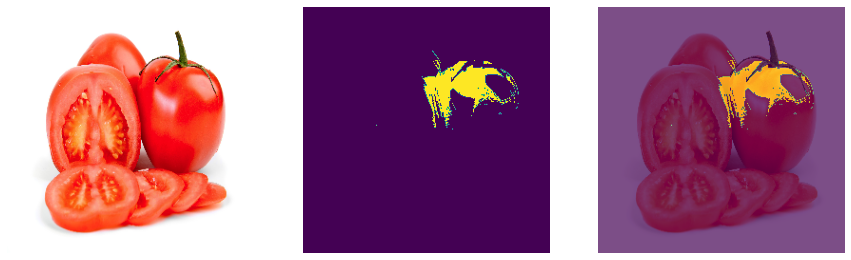

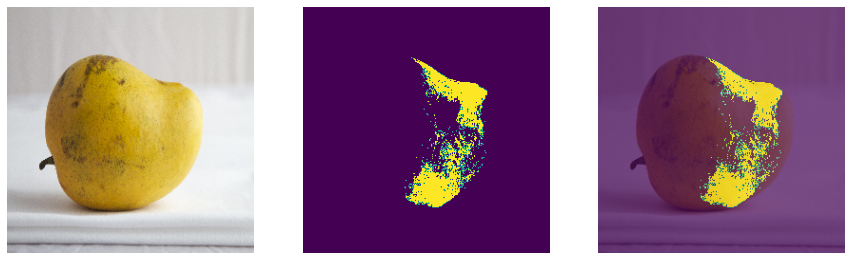

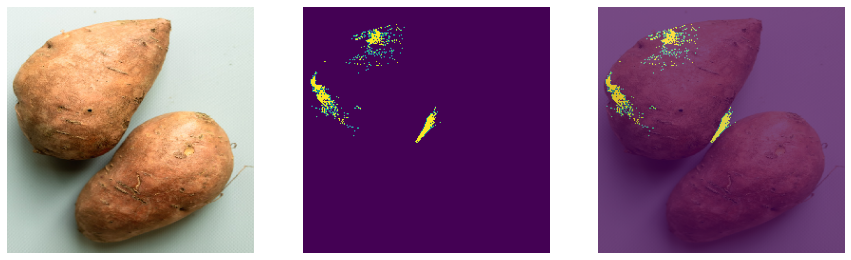

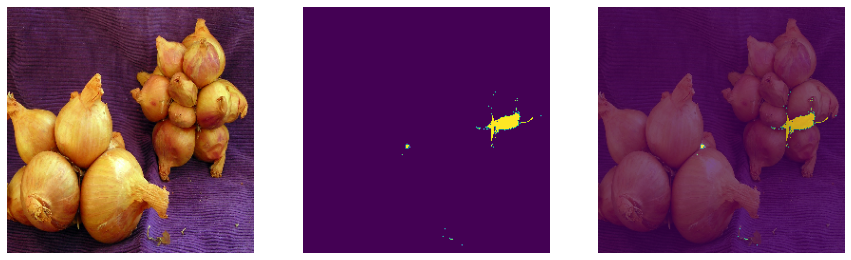

In [ ]:
for i in range(14):
    show_lime_superpixels(model_eff, test_df.Filepath.iloc[wrong_predictions[i]], (260, 260), 3)

### Model comparison
We can compare the models according to the resulting accuracy, because when he wants to classify the category of an image, we are mainly interested in whether the model hit or not. Next we can compare how fast the model got to some reasonable accuracy (after how many epochs).

Baseline model training history


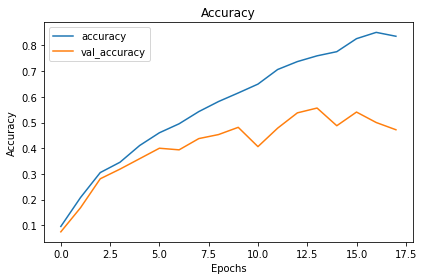

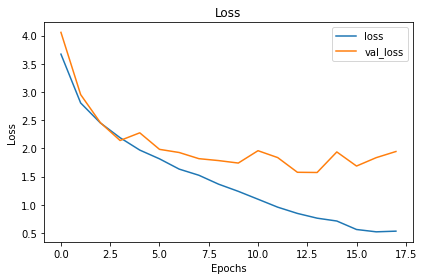

EfficientNetB2 model training history


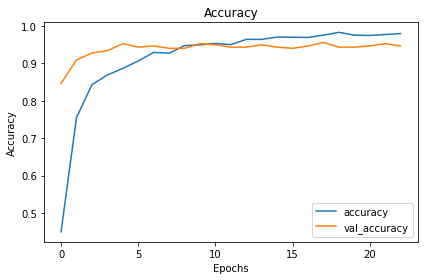

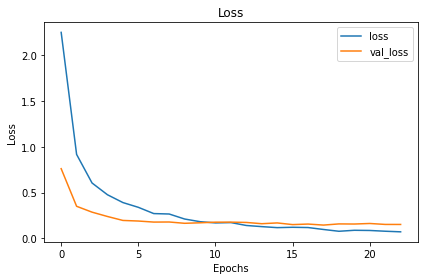

In [12]:
print("Baseline model training history")
plot_loss_acc(history_base)
print("EfficientNetB2 model training history")
plot_loss_acc(history_eff)


Baseline model final accuracy: 47.812% after 14 epochs

EfficientNetB2 model final accuracy: 95.625% after 18 epochs.

Random selection would achieve accuracy: 1/32 = 0.03125%

Simply put, EfficientNetB2 is clearly superior.